In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
train_x_2

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
10572175,7660,1375,8,1.000277,1.000499,1.000000,1.000388,0.574281,103.592369,0.665410,0.266649,48.100475
10572176,7660,1376,8,1.000333,1.000388,0.999834,1.000277,1.350429,243.535217,0.804037,0.487857,87.985291
10572177,7660,1377,8,1.000277,1.000388,0.999834,1.000277,0.692170,124.846756,0.781857,0.360461,65.018936
10572178,7660,1378,8,1.000166,1.000222,0.999778,1.000056,0.556481,100.351929,0.670955,0.296588,53.486565


In [4]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [5]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [6]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [7]:
train_df = np.concatenate([x_train, y_train], axis = 1) 
train_df = train_df[:,:,[0,1,2,3,4]] 

test_df = x_test[:,:,[0,1,2,3,4]] 

In [8]:
train_df.shape, test_df.shape # (batch, length, (index, close, volume))

((7661, 1500, 5), (535, 1380, 5))

In [9]:
train_df[:,:,0] /= 10.0 # scale down the ids 

In [10]:
test_df[:,:,0] /= 10.0 # scale down the ids 

In [20]:
# define close prices 
x_test_close = test_df[:,:,4] 
x_test_close.shape

(535, 1380)

In [28]:
x_train_close = x_train[:,:,4] 
y_train_close = y_train[:,:,4] 

# Preprocess Data
Given time series data (t_1, t_2, ..., tN) predict t{N+K} Here, we let K = 120 and N is a hyperparameter, but we can let it be 60 minutes.

When using a seq2seq based model, so we have n sequences of (t_1, t_2, ..., t_N) and for the decoder, we will have n sequences of (t_{K+1}...,t_{N+K-2},t_{N+K-1}) - not applicable at this time. 

In [11]:
K = 120 
N = 60 
seq_len = 1500 
features = 5
X = [] 
Y = [] 

for j in tqdm(range(train_df.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X.append(train_df[j, i:i+N, :]) 
        Y.append(train_df[j, i+N+K, 4]) # get only close prices as target 
        i += 1   
        
        
X = np.asarray(X) 
Y = np.asarray(Y)

X.shape, Y.shape

100%|██████████| 7661/7661 [00:11<00:00, 664.19it/s]


((10112520, 60, 5), (10112520,))

# Define Model

In [12]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    
def build_transformer(node = 128, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    inputs = Input((N, features))
    bn = BatchNormalization()(inputs)
    x = Conv1D(node*2, 5, activation = activation)(bn) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation) 
        
    x = LSTM(64, return_sequences = True)(x)  
    x = Dropout(drop_rate)(x)
    x = LSTM(64, return_sequences = False)(x) 
    x = Dropout(drop_rate)(x) 
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=inputs,outputs=x) 
    model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [13]:
def build_GRU(): 
    inputs = Input((N,features)) 
    bn = BatchNormalization()(inputs)
    gru = GRU(128, return_sequences = True)(bn)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = True)(gru)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = False)(gru)  
    dense = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(gru) 
    dense = BatchNormalization()(dense) 
    outputs = Dense(1, activation = 'relu')(dense) 
    model = Model(inputs=inputs, outputs = outputs) 
    model.compile(loss='mse', optimizer = 'adam', metrics = ['mae', 'mape','mse']) 
    return model

In [14]:
model = build_transformer()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 5)        20          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 56, 256)      6656        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 18, 256)      0           conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
model_path = 'transformer_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                    Y, 
                    batch_size = 64, ## avoid OOM 
                    epochs = 20, 
                    callbacks = [learning_rate_reduction, checkpoint], 
                    validation_split = 0.1)


Epoch 1/20
142208/142208 [==============================] - 2311s 16ms/step - loss: 8.6774e-04 - mae: 0.0169 - mse: 8.6774e-04 - mape: 1.6865 - val_loss: 3.9681e-04 - val_mae: 0.0108 - val_mse: 3.9681e-04 - val_mape: 1.0688

Epoch 00001: val_loss improved from inf to 0.00040, saving model to transformer_epoch_001_val_0.000.h5
Epoch 2/20
142208/142208 [==============================] - 2250s 16ms/step - loss: 3.5983e-04 - mae: 0.0121 - mse: 3.5983e-04 - mape: 1.2090 - val_loss: 4.1086e-04 - val_mae: 0.0109 - val_mse: 4.1086e-04 - val_mape: 1.0881

Epoch 00002: val_loss did not improve from 0.00040
Epoch 3/20
142208/142208 [==============================] - 2260s 16ms/step - loss: 3.3578e-04 - mae: 0.0117 - mse: 3.3578e-04 - mape: 1.1710 - val_loss: 4.1144e-04 - val_mae: 0.0112 - val_mse: 4.1144e-04 - val_mape: 1.1196

Epoch 00003: val_loss did not improve from 0.00040
Epoch 4/20
 25018/142208 [====>.........................] - ETA: 29:44 - loss: 3.2894e-04 - mae: 0.0116 - mse: 3.2894e-0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 55051/142208 [==========>...................] - ETA: 22:16 - loss: 3.2950e-04 - mae: 0.0116 - mse: 3.2950e-04 - mape: 1.1606

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98391/142208 [===================>..........] - ETA: 11:07 - loss: 3.3002e-04 - mae: 0.0116 - mse: 3.3002e-04 - mape: 1.1595

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



127525/142208 [=========================>....] - ETA: 3:44 - loss: 3.2994e-04 - mae: 0.0116 - mse: 3.2994e-04 - mape: 1.1586

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15931/142208 [==>...........................] - ETA: 31:38 - loss: 3.1958e-04 - mae: 0.0114 - mse: 3.1958e-04 - mape: 1.1386

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 45802/142208 [========>.....................] - ETA: 24:14 - loss: 3.1918e-04 - mae: 0.0114 - mse: 3.1918e-04 - mape: 1.1360

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 74502/142208 [==============>...............] - ETA: 17:04 - loss: 3.1886e-04 - mae: 0.0113 - mse: 3.1886e-04 - mape: 1.1353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



105383/142208 [=====================>........] - ETA: 9:18 - loss: 3.1858e-04 - mae: 0.0113 - mse: 3.1858e-04 - mape: 1.1349

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



135988/142208 [===========================>..] - ETA: 1:34 - loss: 3.1827e-04 - mae: 0.0113 - mse: 3.1827e-04 - mape: 1.1344

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 22870/142208 [===>..........................] - ETA: 29:49 - loss: 3.1556e-04 - mae: 0.0113 - mse: 3.1556e-04 - mape: 1.1321

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 49126/142208 [=========>....................] - ETA: 23:18 - loss: 3.1506e-04 - mae: 0.0113 - mse: 3.1506e-04 - mape: 1.1300

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 75468/142208 [==============>...............] - ETA: 16:42 - loss: 3.1500e-04 - mae: 0.0113 - mse: 3.1500e-04 - mape: 1.1295

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100665/142208 [====================>.........] - ETA: 10:24 - loss: 3.1493e-04 - mae: 0.0113 - mse: 3.1493e-04 - mape: 1.1292

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



127421/142208 [=========================>....] - ETA: 3:42 - loss: 3.1483e-04 - mae: 0.0113 - mse: 3.1483e-04 - mape: 1.1290

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 2241s 16ms/step - loss: 3.1477e-04 - mae: 0.0113 - mse: 3.1477e-04 - mape: 1.1288 - val_loss: 5.6647e-04 - val_mae: 0.0108 - val_mse: 5.6647e-04 - val_mape: 1.0652

Epoch 00006: val_loss did not improve from 0.00035
Epoch 7/20
 10191/142208 [=>............................] - ETA: 32:45 - loss: 3.1448e-04 - mae: 0.0112 - mse: 3.1448e-04 - mape: 1.1238

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 50293/142208 [=========>....................] - ETA: 23:02 - loss: 3.1565e-04 - mae: 0.0113 - mse: 3.1565e-04 - mape: 1.1253

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 81080/142208 [================>.............] - ETA: 15:16 - loss: 3.1527e-04 - mae: 0.0112 - mse: 3.1527e-04 - mape: 1.1247

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



112010/142208 [======================>.......] - ETA: 7:33 - loss: 3.1491e-04 - mae: 0.0112 - mse: 3.1491e-04 - mape: 1.1242

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 2234s 16ms/step - loss: 3.1458e-04 - mae: 0.0112 - mse: 3.1458e-04 - mape: 1.1239 - val_loss: 3.5085e-04 - val_mae: 0.0102 - val_mse: 3.5085e-04 - val_mape: 1.0180

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00007: val_loss did not improve from 0.00035
Epoch 8/20
    64/142208 [..............................] - ETA: 36:07 - loss: 3.1454e-04 - mae: 0.0112 - mse: 3.1454e-04 - mape: 1.1205

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 78935/142208 [===============>..............] - ETA: 15:47 - loss: 3.1054e-04 - mae: 0.0112 - mse: 3.1054e-04 - mape: 1.1191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



104524/142208 [=====================>........] - ETA: 9:25 - loss: 3.1036e-04 - mae: 0.0112 - mse: 3.1036e-04 - mape: 1.1189

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



130156/142208 [==========================>...] - ETA: 3:00 - loss: 3.1016e-04 - mae: 0.0112 - mse: 3.1016e-04 - mape: 1.1186

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 12931/142208 [=>............................] - ETA: 32:30 - loss: 3.0938e-04 - mae: 0.0111 - mse: 3.0938e-04 - mape: 1.1141

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 38415/142208 [=======>......................] - ETA: 26:00 - loss: 3.0855e-04 - mae: 0.0111 - mse: 3.0855e-04 - mape: 1.1144

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 63220/142208 [============>.................] - ETA: 19:49 - loss: 3.0868e-04 - mae: 0.0111 - mse: 3.0868e-04 - mape: 1.1147

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100877/142208 [====================>.........] - ETA: 10:22 - loss: 3.0858e-04 - mae: 0.0111 - mse: 3.0858e-04 - mape: 1.1145

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125924/142208 [=========================>....] - ETA: 4:04 - loss: 3.0840e-04 - mae: 0.0111 - mse: 3.0840e-04 - mape: 1.1144

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 2243s 16ms/step - loss: 3.0830e-04 - mae: 0.0111 - mse: 3.0830e-04 - mape: 1.1142 - val_loss: 3.6994e-04 - val_mae: 0.0102 - val_mse: 3.6994e-04 - val_mape: 1.0203

Epoch 00009: val_loss did not improve from 0.00035
Epoch 10/20
  9535/142208 [=>............................] - ETA: 32:47 - loss: 3.0873e-04 - mae: 0.0111 - mse: 3.0873e-04 - mape: 1.1132

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 34438/142208 [======>.......................] - ETA: 26:50 - loss: 3.0781e-04 - mae: 0.0111 - mse: 3.0781e-04 - mape: 1.1123

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 60606/142208 [===========>..................] - ETA: 20:16 - loss: 3.0743e-04 - mae: 0.0111 - mse: 3.0743e-04 - mape: 1.1119

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 86801/142208 [=================>............] - ETA: 13:49 - loss: 3.0749e-04 - mae: 0.0111 - mse: 3.0749e-04 - mape: 1.1120

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



112658/142208 [======================>.......] - ETA: 7:22 - loss: 3.0743e-04 - mae: 0.0111 - mse: 3.0743e-04 - mape: 1.1120

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 2233s 16ms/step - loss: 3.0736e-04 - mae: 0.0111 - mse: 3.0736e-04 - mape: 1.1120 - val_loss: 3.7347e-04 - val_mae: 0.0104 - val_mse: 3.7347e-04 - val_mape: 1.0383

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00010: val_loss did not improve from 0.00035
Epoch 11/20
 11825/142208 [=>............................] - ETA: 32:29 - loss: 3.0469e-04 - mae: 0.0111 - mse: 3.0469e-04 - mape: 1.1078

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 39860/142208 [=======>......................] - ETA: 25:36 - loss: 3.0512e-04 - mae: 0.0111 - mse: 3.0512e-04 - mape: 1.1085

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 64929/142208 [============>.................] - ETA: 19:20 - loss: 3.0524e-04 - mae: 0.0111 - mse: 3.0524e-04 - mape: 1.1082

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 90788/142208 [==================>...........] - ETA: 12:52 - loss: 3.0514e-04 - mae: 0.0111 - mse: 3.0514e-04 - mape: 1.1080

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 2237s 16ms/step - loss: 3.0504e-04 - mae: 0.0111 - mse: 3.0504e-04 - mape: 1.1077 - val_loss: 5.1052e-04 - val_mae: 0.0105 - val_mse: 5.1052e-04 - val_mape: 1.0349

Epoch 00011: val_loss did not improve from 0.00035
Epoch 12/20
142208/142208 [==============================] - 2236s 16ms/step - loss: 3.0498e-04 - mae: 0.0111 - mse: 3.0498e-04 - mape: 1.1084 - val_loss: 3.4309e-04 - val_mae: 0.0102 - val_mse: 3.4309e-04 - val_mape: 1.0164

Epoch 00012: val_loss improved from 0.00035 to 0.00034, saving model to transformer_epoch_012_val_0.000.h5
Epoch 13/20
 12146/142208 [=>............................] - ETA: 32:37 - loss: 3.0889e-04 - mae: 0.0111 - mse: 3.0889e-04 - mape: 1.1108

# Make Prediction

In [16]:
best_model = load_model('transformer_epoch_012_val_0.000.h5') 
best_model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 5)        20          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 56, 256)      6656        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 18, 256)      0           conv1d[0][0]                     
______________________________________________________________________________________________

In [17]:
## We need to preprocess inputs for prediction 
X_test = [] 
for j in tqdm(range(test_df.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-N-K-120, seq_len-N-K):
        X_test.append(test_df[j, i:i+N, :])  

X_test = np.asarray(X_test).reshape((-1,N,features))

X_test.shape 

100%|██████████| 535/535 [00:00<00:00, 12956.52it/s]


(64200, 60, 5)

In [18]:
predicted = best_model.predict(X_test) 
predicted = predicted.reshape((-1,120)) 

predicted.shape 

(535, 120)

In [21]:
## proportion of prices higher than buy price 
## create submission dataframe 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:  
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)

    


100%|██████████| 535/535 [00:00<00:00, 4059.30it/s]


In [22]:
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times 

submission

,sample_id,buy_quantity,sell_time
0,7661,0.058333,119
1,7662,0.641667,65
2,7663,0.000000,112
3,7664,1.000000,27
4,7665,0.000000,48
...,...,...,...
530,8191,1.000000,2
531,8192,0.241667,7
532,8193,0.000000,102
533,8194,0.633333,12


In [23]:
submission.to_csv("transformer_2.csv",index=False)

In [24]:
## proportion of positive returns 
## create submission dataframe 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(1,120):  
        returns = predicted[i,j]-predicted[i,j-1] 
        if returns >= 0:  
            cnt += 1 
    buy_quantity = cnt/119 
    buy_quantities.append(buy_quantity)

    


100%|██████████| 535/535 [00:00<00:00, 3334.40it/s]


In [25]:
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times 
submission

,sample_id,buy_quantity,sell_time
0,7661,0.554622,119
1,7662,0.554622,65
2,7663,0.579832,112
3,7664,0.403361,27
4,7665,0.596639,48
...,...,...,...
530,8191,0.369748,2
531,8192,0.436975,7
532,8193,0.554622,102
533,8194,0.361345,12


In [26]:
submission.to_csv("transformer_2_positive_returns.csv",index=False)

# Visualize Plots

In [27]:
predicted_train = best_model.predict(X[:2400])
predicted_train = predicted_train.reshape((-1,120)) 

predicted_train.shape

(20, 120)

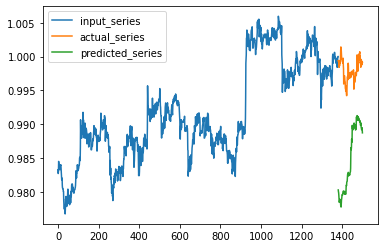

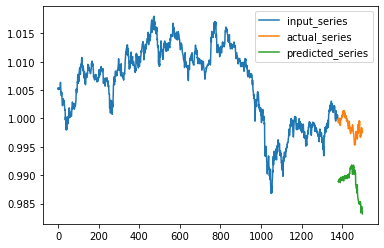

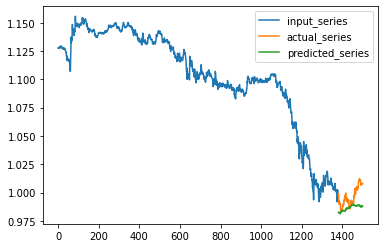

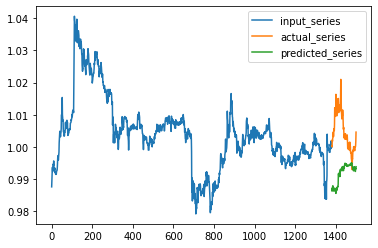

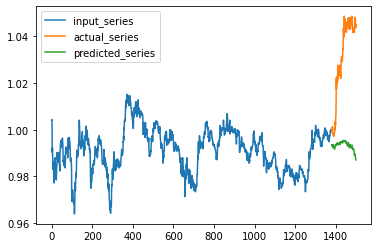

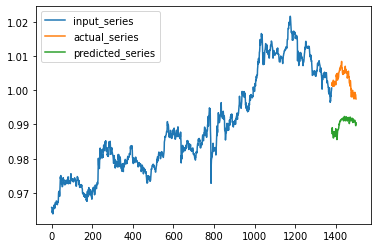

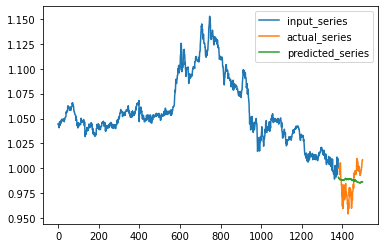

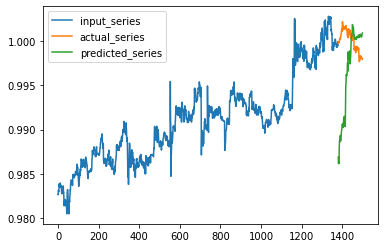

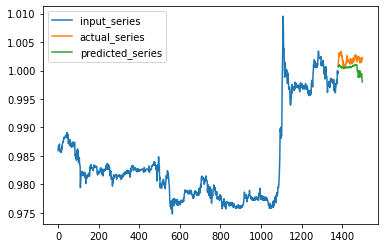

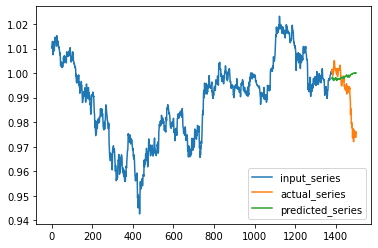

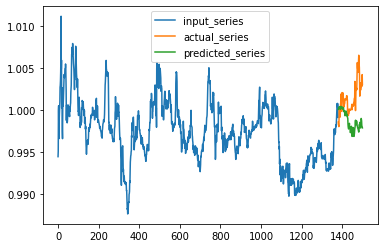

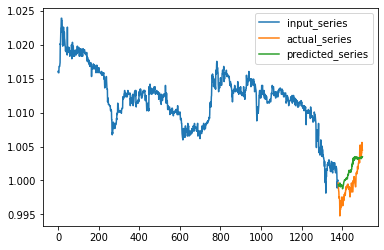

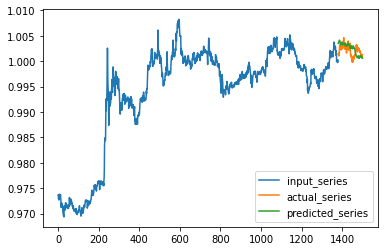

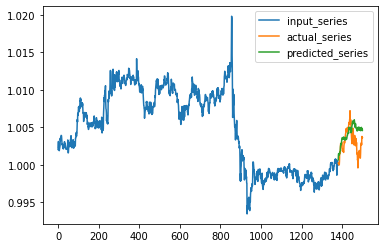

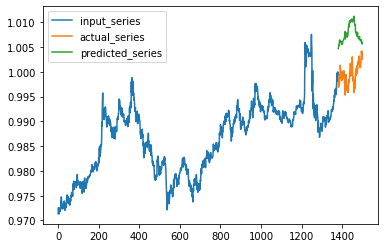

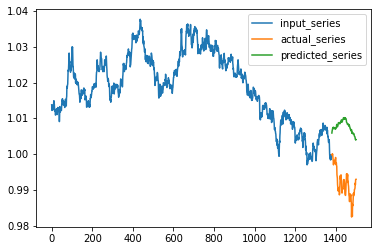

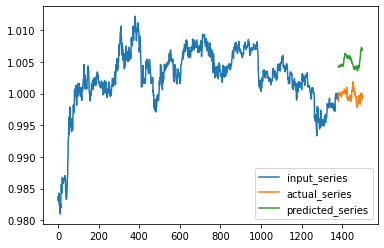

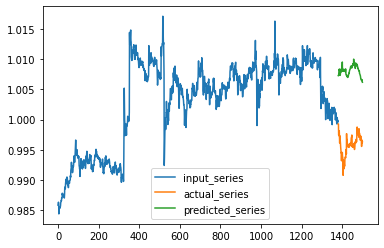

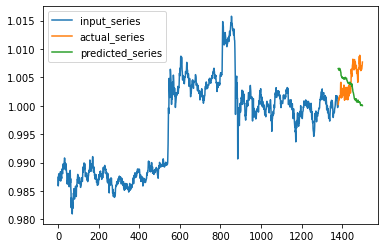

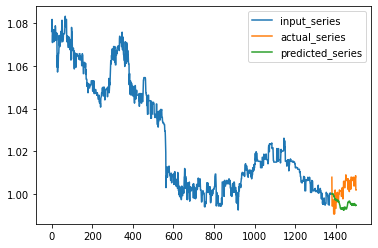

In [31]:
for i in range(20): 
    plt.figure() 
    plot_series(x_train_close[i,:],y_train_close[i,:],predicted_train[i,:])
    plt.show() 